In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys


sys.path.append("../functions")

from Utility import *


In [2]:
raw_data = pd.read_csv("../data/twoArmedandit_with_confidence.csv")
# selecting usefull columns
data = raw_data[
    [
        "sub",
        "condition",
        "cresp",
        "resp",
        "cor",
        "cj",
        "phase",
        "trial",
        "trial_rev",
        "reward",
        "Lreward",
        "Hreward",
    ]
]
# excluding chance level subjects
chance_level_subjects = [45634, 46069, 46279, 46303, 46651, 47398]

# selecting portion of data with proper task
lv_induction_data = data[
    (data["phase"] == "induction")
    & (data["condition"] == "hc")
    & (~data["sub"].isin(chance_level_subjects))
]
subjects = lv_induction_data["sub"].unique()

In [3]:
n_simulation= 100
alpha_list = np.random.uniform(0, 1, n_simulation)
beta_list = np.random.uniform(0,100, n_simulation)
lbound_list = np.random.uniform(1, 5, n_simulation)
range_list = np.random.uniform(0, 1, n_simulation)
agents = np.arange(n_simulation)
subjects = np.random.choice(subjects, size=n_simulation)
params_df = pd.DataFrame(zip(agents, alpha_list, beta_list, lbound_list,
                             range_list, subjects), columns =['agent', 'alpha', "beta", "lbound", "range", "subject"])
params_df["hbound"] = (5 - params_df["lbound"]) * (params_df["range"] ) + params_df["lbound"]


In [4]:
from Forward import simulate_with_params_one
from Forward import simulate_agent
def simulate_with_params_one(params_df, data, subjects):
    df_lists = []
    for i, row in params_df.iterrows():
        params = [row["alpha"], row["beta"], row["lbound"], row["hbound"]]
        subject = int(row["subject"])
        agent = int(row["agent"])
        run = 0
        trials_info = get_subject_task(data, subject)
        resps, rewards, acc, confs, Q_list = simulate_agent(params, trials_info)
        subject_list = [subject] * (len(resps))
        agent_list = [agent]*(len(resps))
        run_list = [run] * (len(resps))
        df = pd.DataFrame(zip(agent_list, subject_list, run_list,resps, rewards, acc, confs, Q_list[:, 0], Q_list[:, 1]),
                      columns=["agent","sub", "run", "resp", "reward", "cor", "cj", "Q1", "Q2"])
        df_lists.append(df)
    return pd.concat(df_lists, axis=0, ignore_index=True)
simulate_df = simulate_with_params_one(params_df, lv_induction_data, data)


In [5]:
from Utility import *
from multiprocessing import Pool
from scipy.optimize import minimize
from Forward import forward_fitting

def get_task_info(data, agent):
    one_subject_data = data[data["agent"] == agent]
    rewards = np.array(one_subject_data["reward"])
    resps = np.array(one_subject_data["resp"])
    confs = np.array(one_subject_data["cj"])
    return {"resps": resps, "rewards": rewards, "confs": confs}

def fit_for_all_agents(params_ranges, n_threads, n_fitting, agents, data, fitting_func):
    """
    Asynchronously Fitting the model to the experimental data
    """
    input_dicts = [get_task_info(data, agent) for agent in agents]

    for d in input_dicts:
        d["n_fitting"] = n_fitting
        d["params_ranges"] = params_ranges

    with Pool(n_threads) as p:
        result = p.map(fitting_func, input_dicts)
    return result


In [6]:
params_ranges = [[0, 1], [0, 100], [1, 5], [0, 1]]
n_fitting = 120
n_threads = 120
res = fit_for_all_agents(
    params_ranges, n_threads, n_fitting, agents, simulate_df, forward_fitting
)
forward_df = make_df_after_fitting(
    res, ["alpha", "beta", "lbound", "bound_range"], agents
)
forward_df["hbound"] = (5 - forward_df["lbound"]) * (
    forward_df["bound_range"]
) + forward_df["lbound"]

In [7]:
from Backward import backward_fitting 

params_ranges = [[0, 1], [0, 100], [1, 5], [0, 1]]
n_fitting = 120
n_threads = 120
res = fit_for_all_agents(
    params_ranges, n_threads, n_fitting, agents, simulate_df, backward_fitting
)
backward_df = make_df_after_fitting(
    res, ["alpha", "beta", "lbound", "bound_range"], agents
)
backward_df["hbound"] = (5 - backward_df["lbound"]) * (
    backward_df["bound_range"]
) + backward_df["lbound"]

In [8]:
forward_recovery = params_df.merge(forward_df, left_on= "agent", right_on="subject")

In [16]:
import scipy

res = scipy.stats.pearsonr(forward_recovery["alpha_x"], forward_recovery["alpha_y"])
res.confidence_interval(.95)

ConfidenceInterval(low=0.9661985807822173, high=0.9846086488132544)

In [50]:
import numpy as np
from scipy import stats

def fisher_z_transform(r):
    """Compute Fisher Z transformation of a correlation coefficient."""
    return 0.5 * np.log((1 + r) / (1 - r))

def compare_correlations(r1, r2, n1, n2):
    """Compare two correlation coefficients using Fisher Z transformation."""
    # Calculate Fisher Z transformations
    Z1 = fisher_z_transform(r1)
    Z2 = fisher_z_transform(r2)

    # Calculate standard errors
    SE1 = 1 / np.sqrt(n1 - 3)
    SE2 = 1 / np.sqrt(n2 - 3)

    # Calculate Z-score for the difference
    Z_diff = (Z1 - Z2) / np.sqrt(SE1**2 + SE2**2)

    # Calculate p-value
    p_value = 2 * (1 - stats.norm.cdf(np.abs(Z_diff)))

    return Z_diff, p_value


(p = 9.72e-68, r = 0.98,ci = [0.97,0.98])


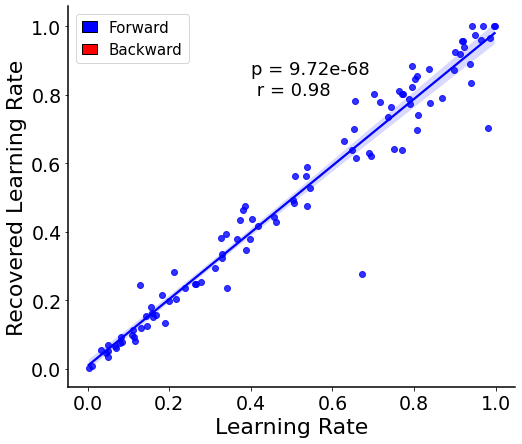

In [61]:
import scipy
import seaborn

from matplotlib.legend_handler import HandlerTuple


plt.figure(figsize=(8, 7))

res = scipy.stats.pearsonr(forward_recovery["alpha_x"], forward_recovery["alpha_y"])

stat_fwd_lr, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f},ci = [{:.2f},{:.2f}])".format(pval, stat_fwd_lr,r_low,r_high))

seaborn.regplot(data=forward_recovery, x="alpha_x", y="alpha_y", color="blue", label= "Forwarad Model")

plt.ylabel("Recovered Learning Rate", fontsize=22)
plt.xlabel("Learning Rate", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.text(0.4, .8, "p = {:.2e} \n r = {:.2f}".format(pval, stat_fwd_lr), fontsize=18)



plt.savefig("../figs/recovery_forward_alpha.png", dpi=400, bbox_inches='tight')


plt.show()

(p = 7.83e-49, r = 0.94,ci = [0.92,0.96])


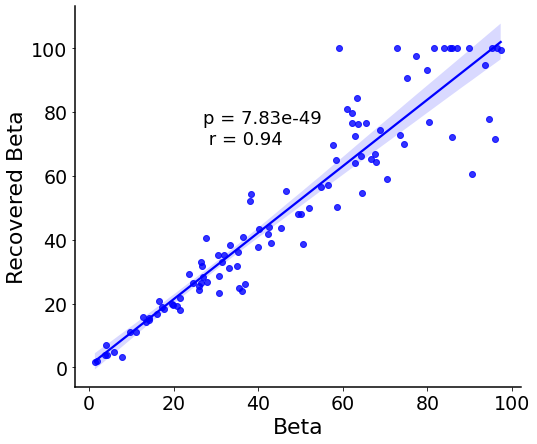

In [52]:
import scipy
import seaborn

plt.figure(figsize=(8, 7))

res = scipy.stats.pearsonr(forward_recovery["beta_x"], forward_recovery["beta_y"])


stat_fwd_beta, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f},ci = [{:.2f},{:.2f}])".format(pval, stat_fwd_beta,r_low,r_high))

seaborn.regplot(data=forward_recovery, x="beta_x", y="beta_y", color="blue", label= "Forwarad Model")

plt.ylabel("Recovered Beta", fontsize=22)
plt.xlabel("Beta", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.text(27, 70, "p = {:.2e} \n r = {:.2f}".format(pval, stat_fwd_beta), fontsize=18)

plt.savefig("../figs/recovery_forward_beta.png", dpi=400, bbox_inches='tight')


plt.show()

(p = 5.02e-150, r = 1.00,ci = [1.00,1.00])


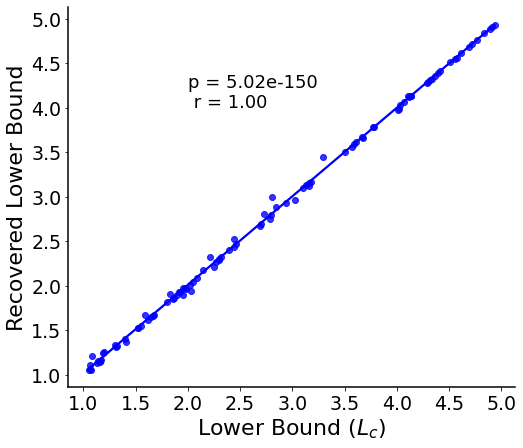

In [24]:
import scipy
import seaborn

plt.figure(figsize=(8, 7))

res = scipy.stats.pearsonr(forward_recovery["lbound_x"], forward_recovery["lbound_y"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f}, ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))


seaborn.regplot(data=forward_recovery, x="lbound_x", y="lbound_y", color="blue", label= "Forwarad Model")

plt.ylabel("Recovered Lower Bound", fontsize=22)
plt.xlabel("Lower Bound "+r"$(L_c$)", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.text(2, 4, "p = {:.2e} \n r = {:.2f}".format(pval, stat), fontsize=18)

plt.savefig("../figs/recovery_forward_lbound.png", dpi=400, bbox_inches='tight')


plt.show()

(p = 2.37e-143, r = 1.00, ci = [1.00,1.00])


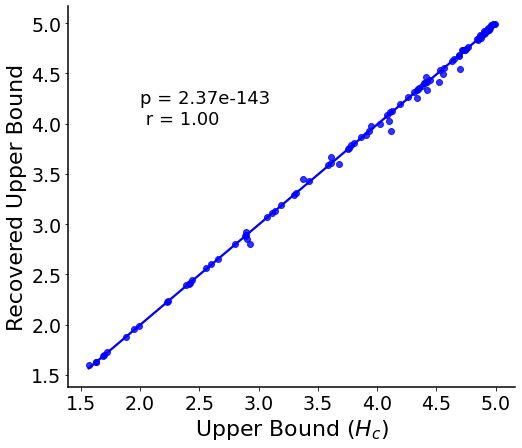

In [25]:
plt.figure(figsize=(8, 7))

res = scipy.stats.pearsonr(forward_recovery["hbound_x"], forward_recovery["hbound_y"])


stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f}, ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))

seaborn.regplot(data=forward_recovery, x="hbound_x", y="hbound_y", color="blue", label= "Forwarad Model")

plt.ylabel("Recovered Upper Bound", fontsize=22)
plt.xlabel("Upper Bound "+r"$(H_c$)", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.text(2, 4, "p = {:.2e} \n r = {:.2f}".format(pval, stat), fontsize=18)

plt.savefig("../figs/recovery_forward_upperbound.png", dpi=400, bbox_inches='tight')


plt.show()

In [103]:
from matplotlib.legend_handler import HandlerTuple

def plot_regression_df(df,x, y, color, pos_x, pos_y, xlabel, ylabel):
    

    res = scipy.stats.pearsonr(df[x], df[y])

    stat_fwd_lr, pval= res 
    r_low, r_high = res.confidence_interval(.95)
    print("(p = {:.2e}, r = {:.2f},ci = [{:.2f},{:.2f}])".format(pval, stat_fwd_lr,r_low,r_high))

    seaborn.regplot(data=df, x=x, y=y, color= color, label= "Forwarad Model")

    plt.ylabel(ylabel, fontsize=22)
    plt.xlabel(xlabel, fontsize=22)

    ax = plt.gca()
    # hide x-axis
    for axis in ["top", "bottom", "left", "right"]:
        ax.spines[axis].set_linewidth(1.5)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.xticks(fontsize=19)
    plt.yticks(fontsize=19)
    plt.text(pos_x, pos_y, "p = {:.2e} \n r = {:.2f}".format(pval, stat_fwd_lr), fontsize=18)
    

(p = 9.72e-68, r = 0.98,ci = [0.97,0.98])
(p = 7.83e-49, r = 0.94,ci = [0.92,0.96])
(p = 5.02e-150, r = 1.00,ci = [1.00,1.00])
(p = 2.37e-143, r = 1.00,ci = [1.00,1.00])


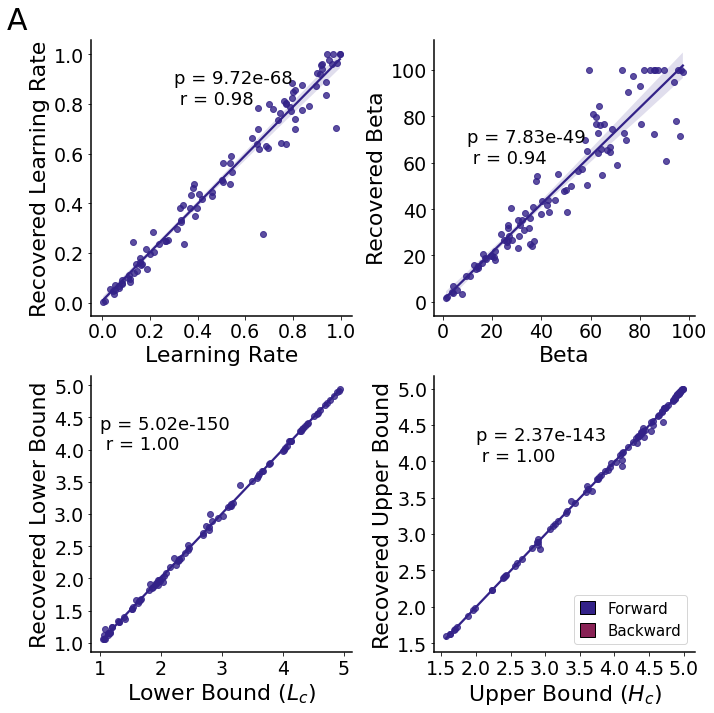

In [134]:
import scipy
import seaborn

from matplotlib.legend_handler import HandlerTuple


fig = plt.figure(figsize=(10, 10))



plt.subplot(2,2,1)
plt.text(-.4, 1.1, "A", fontsize=30)

plot_regression_df(forward_recovery, "alpha_x", "alpha_y", "#332288",0.3, .8, "Learning Rate", "Recovered Learning Rate")


plt.subplot(2,2,2)

plot_regression_df(forward_recovery, "beta_x", "beta_y", "#332288", 10, 60, "Beta","Recovered Beta")


plt.subplot(2,2,3)

plot_regression_df(forward_recovery, "lbound_x", "lbound_y", "#332288", 1, 4, "Lower Bound "+r"$(L_c$)","Recovered Lower Bound")


plt.subplot(2,2,4)

plot_regression_df(forward_recovery, "hbound_x", "hbound_y", "#332288", 2, 4, "Upper Bound "+r"$(H_c$)", "Recovered Upper Bound")

ax = plt.gca()


fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

handles = []

handles.append(plt.Rectangle((0, 0), 0, 0, facecolor="#332288", edgecolor='black'))
handles.append(plt.Rectangle((0, 0), 0, 0, facecolor="#882255", edgecolor='black'))


legend = ax.legend(handles=[tuple(handles[::2]), tuple(handles[1::2])], labels=["Forward", "Backward"], handlelength=1, handleheight=1,handler_map={tuple: HandlerTuple(ndivide=None, pad=0)}, fontsize = 15
         , loc = "lower right")
legend._legend_box.align='left'


plt.savefig("../figs/recovery_forward.png", dpi=400, bbox_inches='tight')


(p = 2.12e-261, r = 1.00,ci = [1.00,1.00])
(p = 1.21e-136, r = 1.00,ci = [1.00,1.00])
(p = 3.03e-160, r = 1.00,ci = [1.00,1.00])
(p = 4.64e-153, r = 1.00,ci = [1.00,1.00])


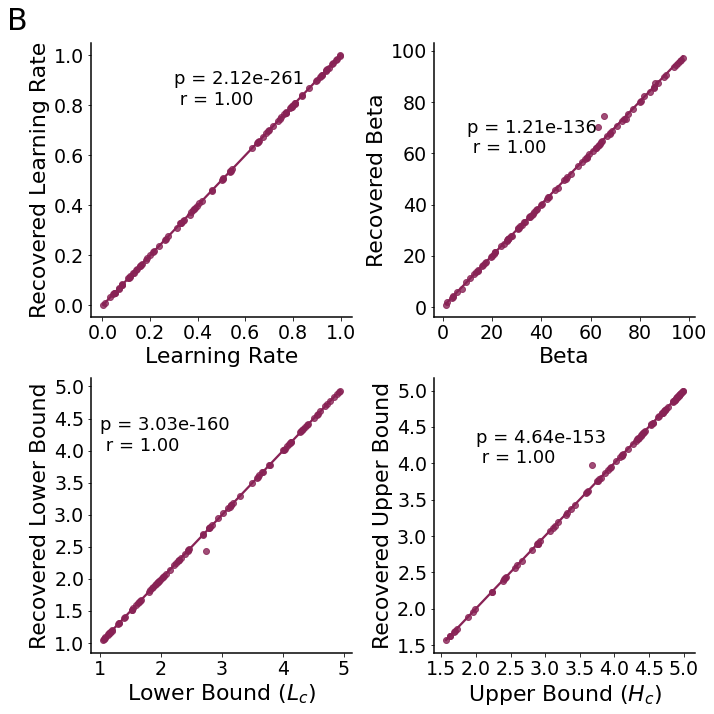

In [120]:
import scipy
import seaborn

from matplotlib.legend_handler import HandlerTuple


fig = plt.figure(figsize=(10, 10))



plt.subplot(2,2,1)
plt.text(-.4, 1.1, "B", fontsize=30)

plot_regression_df(bakcward_recovery, "alpha_x", "alpha_y", "#882255",0.3, .8, "Learning Rate", "Recovered Learning Rate")


plt.subplot(2,2,2)

plot_regression_df(bakcward_recovery, "beta_x", "beta_y", "#882255", 10, 60, "Beta","Recovered Beta")


plt.subplot(2,2,3)

plot_regression_df(bakcward_recovery, "lbound_x", "lbound_y", "#882255", 1, 4, "Lower Bound "+r"$(L_c$)","Recovered Lower Bound")


plt.subplot(2,2,4)

plot_regression_df(bakcward_recovery, "hbound_x", "hbound_y", "#882255", 2, 4, "Upper Bound "+r"$(H_c$)", "Recovered Upper Bound")


fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.savefig("../figs/recovery_backward.png", dpi=400, bbox_inches='tight')


In [26]:
bakcward_recovery = params_df.merge(backward_df, left_on= "agent", right_on="subject")

(p = 2.12e-261, r = 1.00, ci = [1.00,1.00])


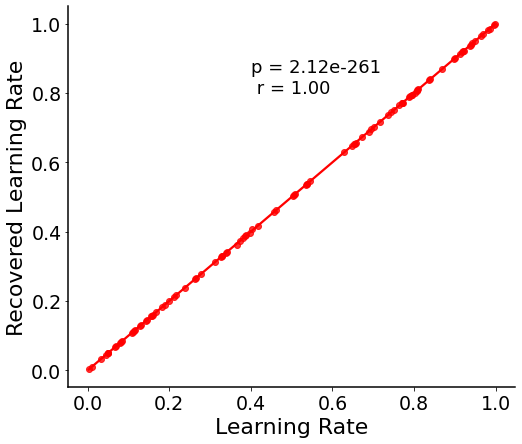

In [53]:
plt.figure(figsize=(8, 7))

res = scipy.stats.pearsonr(bakcward_recovery["alpha_x"], bakcward_recovery["alpha_y"])

stat_bck_lr, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f}, ci = [{:.2f},{:.2f}])".format(pval, stat_bck_lr,r_low,r_high))


seaborn.regplot(data=bakcward_recovery, x="alpha_x", y="alpha_y", color="red", label= "Forwarad Model")

plt.ylabel("Recovered Learning Rate", fontsize=22)
plt.xlabel("Learning Rate", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.text(0.4, .8, "p = {:.2e} \n r = {:.2f}".format(pval, stat_bck_lr), fontsize=18)

plt.savefig("../figs/recovery_backward_alpha.png", dpi=400, bbox_inches='tight')


plt.show()

(p = 1.21e-136, r = 1.00, ci = [1.00,1.00])


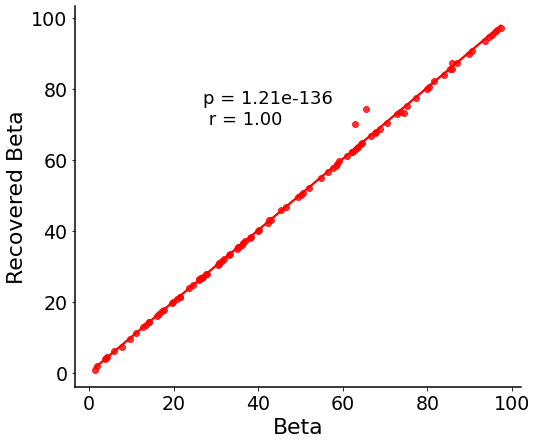

In [54]:
import scipy
import seaborn

plt.figure(figsize=(8, 7))


res = scipy.stats.pearsonr(bakcward_recovery["beta_x"], bakcward_recovery["beta_y"])

stat_bck_beta, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f}, ci = [{:.2f},{:.2f}])".format(pval, stat_bck_beta,r_low,r_high))



seaborn.regplot(data=bakcward_recovery, x="beta_x", y="beta_y", color="red", label= "Forwarad Model")

plt.ylabel("Recovered Beta", fontsize=22)
plt.xlabel("Beta", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.text(27, 70, "p = {:.2e} \n r = {:.2f}".format(pval, stat_bck_beta), fontsize=18)

plt.savefig("../figs/recovery_backward_beta.png", dpi=400, bbox_inches='tight')


plt.show()

In [56]:
r1 = stat_fwd_lr  # Correlation coefficient from dataset 1
r2 = stat_bck_lr # Correlation coefficient from dataset 2
n1 = len(bakcward_recovery)  # Sample size of dataset 1
n2 = len(bakcward_recovery)  # Sample size of dataset 2

Z_diff, p_value = compare_correlations(r1, r2, n1, n2)
Z_diff, p_value


(-31.766867681964985, 0.0)

In [58]:
r1 = stat_fwd_beta  # Correlation coefficient from dataset 1
r2 = stat_bck_beta # Correlation coefficient from dataset 2
n1 = len(bakcward_recovery)  # Sample size of dataset 1
n2 = len(bakcward_recovery)  # Sample size of dataset 2

Z_diff, p_value = compare_correlations(r1, r2, n1, n2)
Z_diff, p_value


(-14.560938528543637, 0.0)

In [57]:
bakcward_recovery

,agent,alpha_x,beta_x,lbound_x,range,subject_x,hbound_x,subject_y,alpha_y,beta_y,lbound_y,bound_range,LL,Confidence Distance,hbound_y
0,0,0.750862,42.661685,4.913253,0.887854,46828,4.990272,0.0,0.751212,43.109918,4.913348,0.887380,27.426166,2.809999e-09,4.990241
1,1,0.656546,20.719196,4.333527,0.924759,46198,4.949854,1.0,0.656547,20.719221,4.333527,0.924759,90.945023,8.332333e-15,4.949854
2,2,0.216341,46.652402,3.499597,0.391235,46072,4.086607,2.0,0.216341,46.652421,3.499597,0.391235,56.846525,7.258304e-15,4.086607
3,3,0.167038,56.583701,3.612874,0.469247,46822,4.263778,3.0,0.167038,56.583489,3.612873,0.469247,70.446635,1.047840e-13,4.263778
4,4,0.836424,51.967033,1.312945,0.624128,45664,3.614141,4.0,0.836424,51.967045,1.312945,0.624128,16.600040,4.525525e-15,3.614141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,0.113655,26.595714,4.766379,0.561630,45964,4.897587,95.0,0.113645,26.592939,4.766374,0.561666,183.272341,4.361847e-12,4.897594
96,96,0.651630,58.340201,4.030098,0.761844,45745,4.769012,96.0,0.651630,58.340145,4.030097,0.761844,19.632650,2.446803e-14,4.769012
97,97,0.327594,66.672368,4.138233,0.706772,46828,4.747306,97.0,0.327593,66.672815,4.138233,0.706771,33.193147,1.604112e-13,4.747305
98,98,0.916975,16.056945,1.802872,0.657733,46672,3.905728,98.0,0.916975,16.056951,1.802872,0.657733,94.684916,1.399823e-14,3.905728


(p = 3.03e-160, r = 1.00, ci = [1.00,1.00])


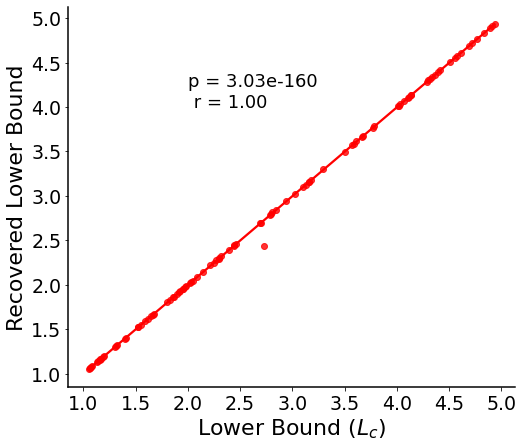

In [29]:
plt.figure(figsize=(8, 7))

res = scipy.stats.pearsonr(bakcward_recovery["lbound_x"], bakcward_recovery["lbound_y"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f}, ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))


seaborn.regplot(data=bakcward_recovery, x="lbound_x", y="lbound_y", color="red", label= "Forwarad Model")

plt.ylabel("Recovered Lower Bound", fontsize=22)
plt.xlabel("Lower Bound " + r"$(L_c$)", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.text(2, 4, "p = {:.2e} \n r = {:.2f}".format(pval, stat), fontsize=18)

plt.savefig("../figs/recovery_backward_lbound.png", dpi=400, bbox_inches='tight')


plt.show()

(p = 4.64e-153, r = 1.00, ci = [1.00,1.00])


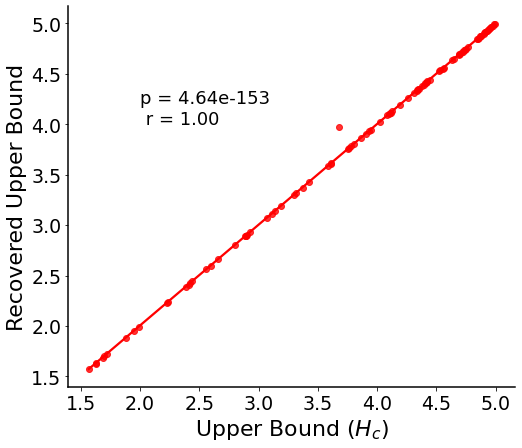

In [30]:
plt.figure(figsize=(8, 7))

res = scipy.stats.pearsonr(bakcward_recovery["hbound_x"], bakcward_recovery["hbound_y"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f}, ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))

seaborn.regplot(data=bakcward_recovery, x="hbound_x", y="hbound_y", color="red", label= "Forwarad Model")

plt.ylabel("Recovered Upper Bound", fontsize=22)
plt.xlabel("Upper Bound " + r"$(H_c$)", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.text(2, 4, "p = {:.2e} \n r = {:.2f}".format(pval, stat), fontsize=18)

plt.savefig("../figs/recovery_backward_upperbound.png", dpi=400, bbox_inches='tight')


plt.show()

In [31]:
forward_recovery

,agent,alpha_x,beta_x,lbound_x,range,subject_x,hbound_x,subject_y,alpha_y,beta_y,lbound_y,bound_range,LL,Confidence Distance,hbound_y
0,0,0.750862,42.661685,4.913253,0.887854,46828,4.990272,0.0,0.641257,43.958692,4.913497,0.887898,26.413095,0.000004,4.990303
1,1,0.656546,20.719196,4.333527,0.924759,46198,4.949854,1.0,0.616985,19.260259,4.328897,0.935716,90.168255,0.000060,4.956859
2,2,0.216341,46.652402,3.499597,0.391235,46072,4.086607,2.0,0.203012,55.256477,3.506141,0.385593,56.273736,0.000056,4.082162
3,3,0.167038,56.583701,3.612874,0.469247,46822,4.263778,3.0,0.157499,57.194653,3.613692,0.470059,70.317047,0.000032,4.265338
4,4,0.836424,51.967033,1.312945,0.624128,45664,3.614141,4.0,0.876285,50.053703,1.317520,0.623493,16.441465,0.000850,3.613520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,0.113655,26.595714,4.766379,0.561630,45964,4.897587,95.0,0.094123,33.086458,4.768262,0.550217,182.599262,0.000007,4.895768
96,96,0.651630,58.340201,4.030098,0.761844,45745,4.769012,96.0,0.699117,65.085293,4.028494,0.760154,19.084897,0.000183,4.766988
97,97,0.327594,66.672368,4.138233,0.706772,46828,4.747306,97.0,0.382987,65.374237,4.135161,0.703646,31.156308,0.000651,4.743701
98,98,0.916975,16.056945,1.802872,0.657733,46672,3.905728,98.0,0.957626,16.887147,1.815824,0.650242,94.271938,0.000606,3.886310


In [34]:
all_recovery = forward_recovery.merge(bakcward_recovery, on= "agent")
all_recovery

,agent,alpha_x_x,beta_x_x,lbound_x_x,range_x,subject_x_x,hbound_x_x,subject_y_x,alpha_y_x,beta_y_x,...,subject_x_y,hbound_x_y,subject_y_y,alpha_y_y,beta_y_y,lbound_y_y,bound_range_y,LL_y,Confidence Distance_y,hbound_y_y
0,0,0.750862,42.661685,4.913253,0.887854,46828,4.990272,0.0,0.641257,43.958692,...,46828,4.990272,0.0,0.751212,43.109918,4.913348,0.887380,27.426166,2.809999e-09,4.990241
1,1,0.656546,20.719196,4.333527,0.924759,46198,4.949854,1.0,0.616985,19.260259,...,46198,4.949854,1.0,0.656547,20.719221,4.333527,0.924759,90.945023,8.332333e-15,4.949854
2,2,0.216341,46.652402,3.499597,0.391235,46072,4.086607,2.0,0.203012,55.256477,...,46072,4.086607,2.0,0.216341,46.652421,3.499597,0.391235,56.846525,7.258304e-15,4.086607
3,3,0.167038,56.583701,3.612874,0.469247,46822,4.263778,3.0,0.157499,57.194653,...,46822,4.263778,3.0,0.167038,56.583489,3.612873,0.469247,70.446635,1.047840e-13,4.263778
4,4,0.836424,51.967033,1.312945,0.624128,45664,3.614141,4.0,0.876285,50.053703,...,45664,3.614141,4.0,0.836424,51.967045,1.312945,0.624128,16.600040,4.525525e-15,3.614141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,0.113655,26.595714,4.766379,0.561630,45964,4.897587,95.0,0.094123,33.086458,...,45964,4.897587,95.0,0.113645,26.592939,4.766374,0.561666,183.272341,4.361847e-12,4.897594
96,96,0.651630,58.340201,4.030098,0.761844,45745,4.769012,96.0,0.699117,65.085293,...,45745,4.769012,96.0,0.651630,58.340145,4.030097,0.761844,19.632650,2.446803e-14,4.769012
97,97,0.327594,66.672368,4.138233,0.706772,46828,4.747306,97.0,0.382987,65.374237,...,46828,4.747306,97.0,0.327593,66.672815,4.138233,0.706771,33.193147,1.604112e-13,4.747305
98,98,0.916975,16.056945,1.802872,0.657733,46672,3.905728,98.0,0.957626,16.887147,...,46672,3.905728,98.0,0.916975,16.056951,1.802872,0.657733,94.684916,1.399823e-14,3.905728


(p = 9.17e-68, r = 0.98,ci = [0.97,0.98])


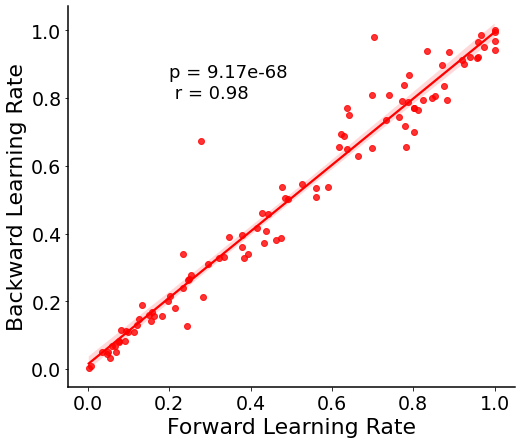

In [45]:
plt.figure(figsize=(8, 7))

res = scipy.stats.pearsonr(all_recovery["alpha_y_x"], all_recovery["alpha_y_y"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f},ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))

seaborn.regplot(data=all_recovery, x="alpha_y_x", y="alpha_y_y", color="red", label= "Forwarad Model")

plt.ylabel("Backward Learning Rate", fontsize=22)
plt.xlabel("Forward Learning Rate", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.text(0.2, .8, "p = {:.2e} \n r = {:.2f}".format(pval, stat), fontsize=18)

plt.savefig("../figs/recovery_for_back_alpha.png", dpi=400, bbox_inches='tight')


plt.show()

(p = 2.53e-49, r = 0.94,ci = [0.92,0.96])


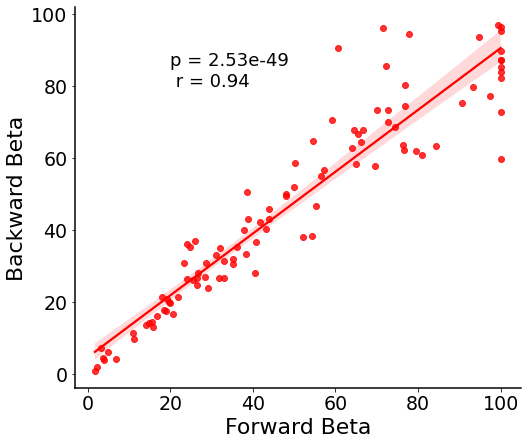

In [46]:
plt.figure(figsize=(8, 7))

res = scipy.stats.pearsonr(all_recovery["beta_y_x"], all_recovery["beta_y_y"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f},ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))

seaborn.regplot(data=all_recovery, x="beta_y_x", y="beta_y_y", color="red", label= "Forwarad Model")

plt.ylabel("Backward Beta", fontsize=22)
plt.xlabel("Forward Beta", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.text(20,80, "p = {:.2e} \n r = {:.2f}".format(pval, stat), fontsize=18)

plt.savefig("../figs/recovery_for_back_beta.png", dpi=400, bbox_inches='tight')


plt.show()

(p = 2.85e-136, r = 1.00,ci = [1.00,1.00])


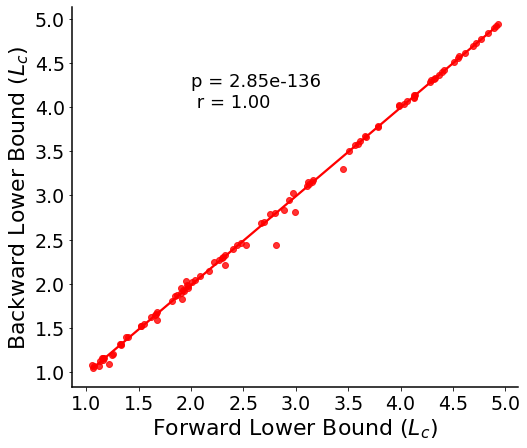

In [47]:
plt.figure(figsize=(8, 7))

res = scipy.stats.pearsonr(all_recovery["lbound_y_x"], all_recovery["lbound_y_y"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f},ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))

seaborn.regplot(data=all_recovery, x="lbound_y_x", y="lbound_y_y", color="red", label= "Forwarad Model")

plt.ylabel("Backward Lower Bound " + r"$(L_c$)", fontsize=22)
plt.xlabel("Forward Lower Bound " + r"$(L_c$)", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.text(2, 4, "p = {:.2e} \n r = {:.2f}".format(pval, stat), fontsize=18)

plt.savefig("../figs/recovery_for_back_lbound.png", dpi=400, bbox_inches='tight')


plt.show()

(p = 2.76e-129, r = 1.00,ci = [1.00,1.00])


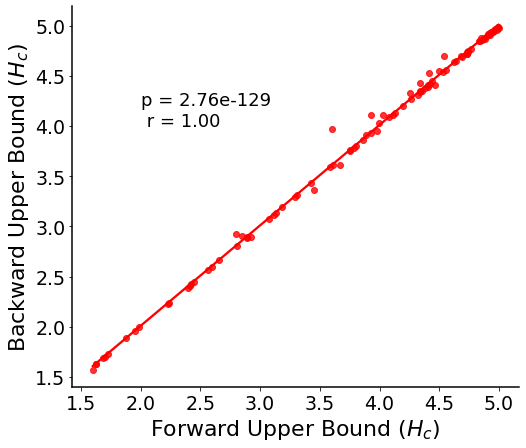

In [48]:
plt.figure(figsize=(8, 7))

res = scipy.stats.pearsonr(all_recovery["hbound_y_x"], all_recovery["hbound_y_y"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f},ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))

seaborn.regplot(data=all_recovery, x="hbound_y_x", y="hbound_y_y", color="red", label= "Forwarad Model")

plt.ylabel("Backward Upper Bound " + r"$(H_c$)", fontsize=22)
plt.xlabel("Forward Upper Bound " + r"$(H_c$)", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.text(2, 4, "p = {:.2e} \n r = {:.2f}".format(pval, stat), fontsize=18)

plt.savefig("../figs/recovery_for_back_hbound.png", dpi=400, bbox_inches='tight')


plt.show()

(p = 9.17e-68, r = 0.98,ci = [0.97,0.98])
(p = 2.53e-49, r = 0.94,ci = [0.92,0.96])
(p = 2.85e-136, r = 1.00,ci = [1.00,1.00])
(p = 2.76e-129, r = 1.00,ci = [1.00,1.00])


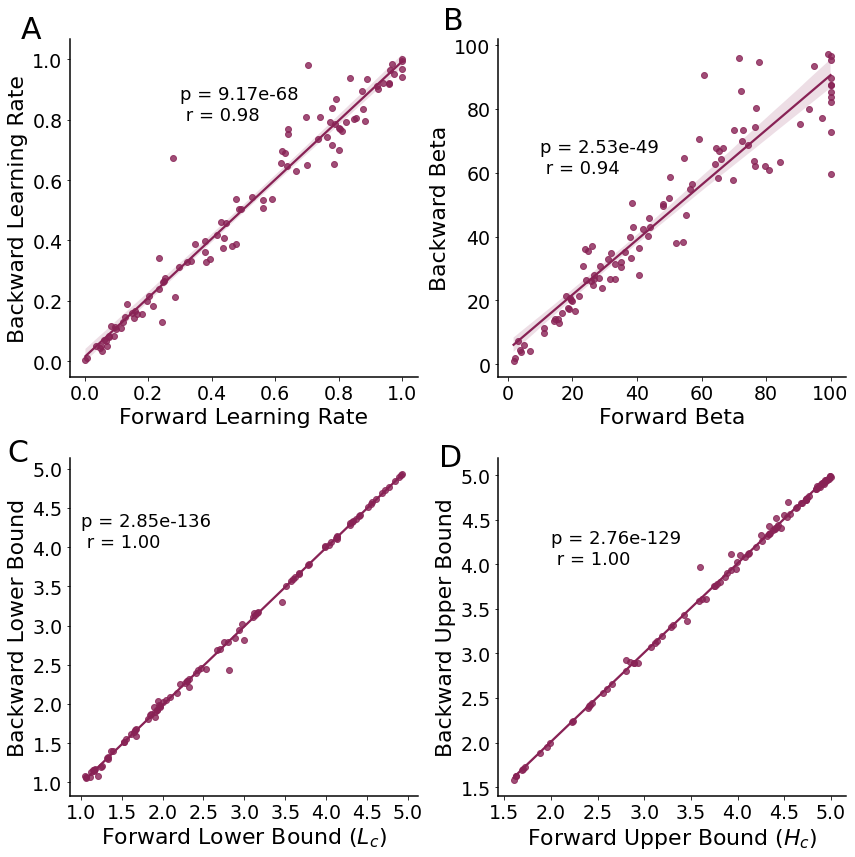

In [153]:
import scipy
import seaborn

from matplotlib.legend_handler import HandlerTuple


fig = plt.figure(figsize=(12, 12))



plt.subplot(2,2,1)
plt.text(-.2, 1.07, "A", fontsize=30)

plot_regression_df(all_recovery, "alpha_y_x", "alpha_y_y", "#882255",0.3, .8, "Forward Learning Rate", "Backward Learning Rate")


plt.subplot(2,2,2)
plt.text(-20, 105, "B", fontsize=30)

plot_regression_df(all_recovery, "beta_y_x", "beta_y_y", "#882255", 10, 60, "Forward Beta","Backward Beta")


plt.subplot(2,2,3)
plt.text(.1, 5.1, "C", fontsize=30)

plot_regression_df(all_recovery, "lbound_y_x", "lbound_y_y", "#882255", 1, 4, "Forward Lower Bound "+r"$(L_c$)","Backward Lower Bound")


plt.subplot(2,2,4)

plt.text(.8, 5.1, "D", fontsize=30)

plot_regression_df(all_recovery, "hbound_y_x", "hbound_y_y", "#882255", 2, 4, "Forward Upper Bound "+r"$(H_c$)", "Backward Upper Bound")


fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.savefig("../figs/recovery_corr_sup.png", dpi=400, bbox_inches='tight')
